In [10]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

import cv2
import mediapipe as mp
import os
import numpy as np
from config import OUTPUT_FOLDER, MODEL_PATH
from lib.ToothClassifier import ToothClassifier,FDI_MAP


Model = YOLO(MODEL_PATH)
mp_face_detection = mp.solutions.face_detection
mp_face_mesh = mp.solutions.face_mesh
face_mesh=mp_face_mesh.FaceMesh(
            min_detection_confidence=0.2,
            min_tracking_confidence=0.2)


mouse=[62,96,89,179,86,15,316,403,319,325,292,407,272,271,268,12,38,41,42,183]#嘴巴
lip=[78,95,88,178,87,14,317,402,318,324,308,415,310,311,312,13,82,81,80,191]#嘴唇
mid_line = [10,9,8,6,5,4,1,0]# 中線

class SMILE:
    def __init__(self,input_path, device='cpu',filter=0.9):
        self.device=device
        #####Input/output#####
        self.input_path=input_path 

        self.output_path=f"{OUTPUT_FOLDER}output.jpeg" 
        """圖片輸出路徑"""



        #####Image normalize#####
        img=cv2.imread(input_path)
        h, w ,d= img.shape
        self.img=cv2.resize(img, (1024, int(1024*h/w)), interpolation=cv2.INTER_AREA)
        self.shape=self.img.shape
        """原圖shape"""

        #####Find mouse#####
        self.mouse=[]
        self.box=[]
        """嘴巴Box"""
        self.boximg=[]
        """裁切只保留嘴巴img"""
        self.box_pol=[]
        """boximg切割的座標"""

        self.rotation_matrix=[]
        """旋轉矩陣"""
        self.rotated_img=''
        """轉完的矩陣"""
        


        #####Result#####
        self.filter=filter
        self.tooth=[]
        """
        [center_x,center_y,w,h]
        """
        self.tooth_cls=[]
        """牙齒類別"""

        self.ntooth=0
        """牙齒數"""
        print('SMILE_init')


        #### set_model###


        pass


    def find_all_tooth(self):
        """try:
            self.find_mouse()
            print (f'found mouth')
        except:
            return False"""
        self.find_mouse()

        result = Model.predict(
            source=self.output_path,
            mode="predict",
            device=self.device
        )
        
        



        boxes = result[0].boxes
        
        self.tooth=[]
        for box in boxes:
            if box.conf[0]>=self.filter:
                self.tooth.append(box.xywh.tolist()[0] )



        h,w,d=self.boximg.shape

        self.tooth_cls=ToothClassifier(w,h,self.tooth).cls

        self.ntooth=len(self.tooth_cls)


        
        # OUTPUT
        currentAxis = plt.gca()
        img=plt.imread(self.output_path)
        plt.imshow(img)

        colors=plt.cm.hsv(np.linspace(0, 1, self.ntooth)).tolist()   


        for t, cl,c in zip(self.tooth, self.tooth_cls,colors):
            x,y,w,h=tuple(t)
            
            currentAxis.text(x,y, FDI_MAP[cl],bbox={'facecolor': c, 'alpha': 0.5})
            currentAxis.add_patch(plt.Rectangle((x-w/2,y-h/2),w,h,fill=False,edgecolor=c,linewidth=2))


        plt.axis('off')        
        plt.savefig(self.output_path,bbox_inches='tight',pad_inches=0.0, dpi=200)
        #plt.show()
        plt.clf()
        print('img_out')
        return True


    
    
    def find_mouse(self): # 裁切嘴巴區域，存到 output_path
        h, w, d = self.img.shape
        
    
        
    
        #########################openCV辨識嘴 #########################
        RGBim = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(RGBim)

        
        ## 取得臉中線
        midline_x=[]
        midline_y=[]

        if results.multi_face_landmarks:
            for face_landmarks in  results.multi_face_landmarks:
                for index in mid_line:
                    midline_x.append(int(face_landmarks.landmark[index].x * w))
                    midline_y.append(int(face_landmarks.landmark[index].y * h))

        self.get_rotate_matrix(midline_x,midline_y)

        self.rotated_img = cv2.warpAffine(self.img, self.rotation_matrix[:2], (w, h), flags=cv2.INTER_LINEAR)

        
        ## 辨識

        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                #for index in mouse:
                for index in lip:
                    x = int(face_landmarks.landmark[index].x * w)
                    y = int(face_landmarks.landmark[index].y * h)
                    roxy=np.dot(self.rotation_matrix,[[x],[y],[1]])
                    self.mouse.append([x,y])
                    #self.mouse.append([
                    #    int(roxy[0]),
                    #    int(roxy[1])
                    #])
                

        
        

        self.mouse=np.array(self.mouse)

        umos=min(self.mouse[:,1])#嘴上緣
        dmos=max(self.mouse[:,1])#嘴下緣
        lmos=min(self.mouse[:,0])#嘴左緣
        rmos=max(self.mouse[:,0])#嘴右緣
        wmos=rmos-lmos#嘴寬
        hmos=dmos-umos#嘴高
        mmos=[int((lmos+rmos)/2),int((umos+dmos)/2)]#嘴中心

        
        
        ######輸出#####
        self.box=np.array([lmos,rmos,umos,dmos])

    

        self.boximg=self.rotated_img[self.box[2]-5:self.box[3]+5,self.box[0]-5:self.box[1]+5]
        


        self.box_pol=[self.box[0]-5,self.box[2]-5]



        cv2.imwrite(self.output_path,self.boximg)

        return self.box
    
    def get_rotate_matrix(self,x,y):
        A = np.vstack([x, np.ones(len(x))]).T
        m, c = np.linalg.lstsq(A, y, rcond=None)[0]
        m=np.abs(m)
        print(f'{m=}')

            ## 回歸直線
        w,h,d=self.shape

        cy,cx= w/2, h/2

        t1=np.array([[1,0,-cx],
                    [0,1,-cy],
                    [0,0,1]])
        lenth = np.sqrt(1+m*m)

        r=np.array([[m,-1,0],
            [1,m,0],
            [0,0,lenth]])/lenth
        
        t2=np.array([[1,0,cx],
                    [0,1,cy],
                    [0,0,1]])

        self.rotation_matrix = np.dot(t2,np.dot(r, t1))


In [1]:
from lib.Smile import SMILE
smile=SMILE('C:/gits/SMILE_tmp/app/TrainData/data/00043.png', filter=0.65)
smile.find_all_tooth()

SMILE_init
臉中線斜率m=10.598715890850734
found mouth

image 1/1 c:\gits\SMILE_server\app\outputs\output.png: 224x640 2 0s, 10 tooths, 146.1ms
Speed: 1.0ms preprocess, 146.1ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)
[44.761348724365234, 52.7435302734375, 51.72231960296631]
All tooth found and img output


True

<Figure size 640x480 with 0 Axes>

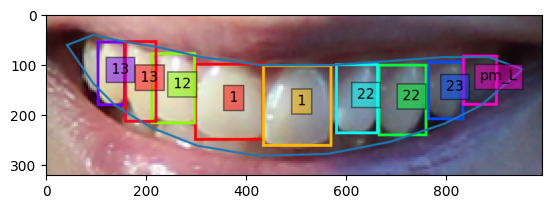

In [2]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(smile.output_path))

In [4]:
print(f"""{''.join(smile.error)=}
{smile.smile_info=}""")

''.join(smile.error)=''
smile.smile_info={'test': 'vault', 'mouth_width': 227, 'mouse_box': [10, 237, 10, 70], 'tooth_num': 9, 'most_posterior_maxillary_teeth': 9, 'arc_ratio': 69, 'buccal_corridor': 13}


In [2]:
import json


json.dumps(smile.smile_info)

'{"test": "vault", "mouth_width": 227, "mouse_box": [10, 237, 10, 70], "tooth_num": 9, "most_posterior_maxillary_teeth": 9, "arc_ratio": 69, "buccal_corridor": 13}'

In [3]:
for key in smile.smile_info:
    print(f'{key=}, {type(smile.smile_info[key])}')
    print(json.dumps({
        key: smile.smile_info[key]
    }))

key='test', <class 'str'>
{"test": "vault"}
key='mouth_width', <class 'int'>
{"mouth_width": 227}
key='mouse_box', <class 'list'>
{"mouse_box": [10, 237, 10, 70]}
key='tooth_num', <class 'int'>
{"tooth_num": 9}
key='most_posterior_maxillary_teeth', <class 'int'>
{"most_posterior_maxillary_teeth": 9}
key='arc_ratio', <class 'int'>
{"arc_ratio": 69}
key='buccal_corridor', <class 'int'>
{"buccal_corridor": 13}


In [4]:
smile.error

['incisor_lower_border not found']

In [73]:
sum(smile.rotated_img)

array([[ 63, 186,   0],
       [169, 221, 133],
       [206, 182, 250],
       ...,
       [112, 125, 242],
       [ 29,  78, 138],
       [ 91, 106, 139]], dtype=uint8)

In [61]:
cy,cx= 512, 512
m=19

t1=np.array([[1,0,-cx],
            [0,1,-cy],
            [0,0,1]])

lenth = np.sqrt(1+m*m)
r=np.array([[m,-1,0],
            [1,m,0],
            [0,0,lenth]])/lenth

t2=np.array([[1,0,cx],
            [0,1,cy],
            [0,0,1]])


mm=np.dot(r, t1)

final = np.dot(t2,mm)
#print(f'{t1=},{r=},{t2=}')


In [82]:
smile.tooth

[[690.1488647460938,
  111.19297790527344,
  106.5140380859375,
  176.31802368164062]]

In [6]:
dct={1:20}
a=[1,2,3]

b=[dct[i] if i in dct else -1  for i in a ]

In [2]:
from requests_toolbelt.multipart.encoder import MultipartEncoder


In [1]:
!pip install requests-toolbelt

     ---------------------------------------- 0.0/54.5 kB ? eta -:--:--
     ---------------------- ----------------- 30.7/54.5 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 54.5/54.5 kB 567.2 kB/s eta 0:00:00


In [1]:
#/bin/python3 -m pip install ipykernel -U --user --force-reinstall
!pip install --upgrade pip 

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.11/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [5]:
for i,c in enumerate([1,2]):
    print(f'{i=},{c=}')

i=0,c=1
i=1,c=2
